Train shape: (216919, 7)
Val shape: (27481, 41)

Columns:
 Index(['Unnamed: 0', 'name', 'ddG_ML', 'mut_type', 'WT_name', 'aa_seq',
       'wt_seq'],
      dtype='str')

After cleaning:
Train shape: (215731, 7)
Val shape: (27328, 41)

Target Statistics (Train):
count    215731.000000
mean         -0.743402
std           1.002268
min          -5.662802
25%          -1.257363
50%          -0.497227
75%          -0.040311
max           3.099443
Name: ddG_ML, dtype: float64
Skewness: -1.0657587434722753
Kurtosis: 1.2767463028016217


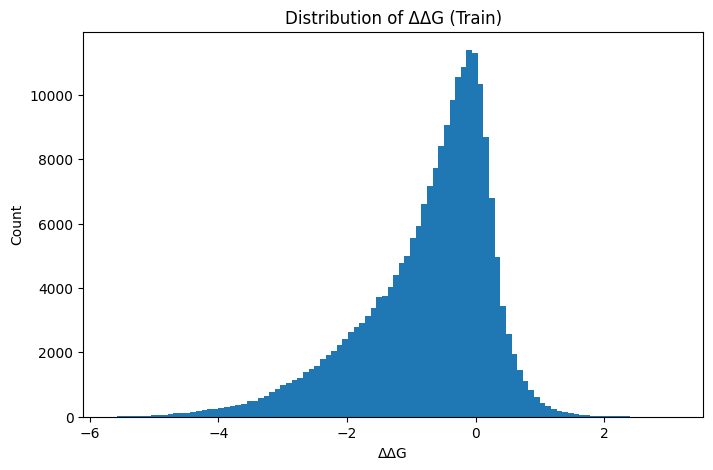

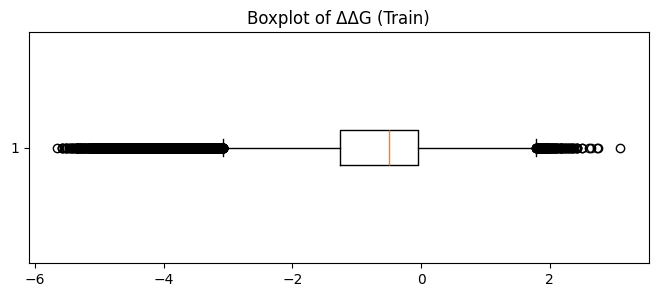

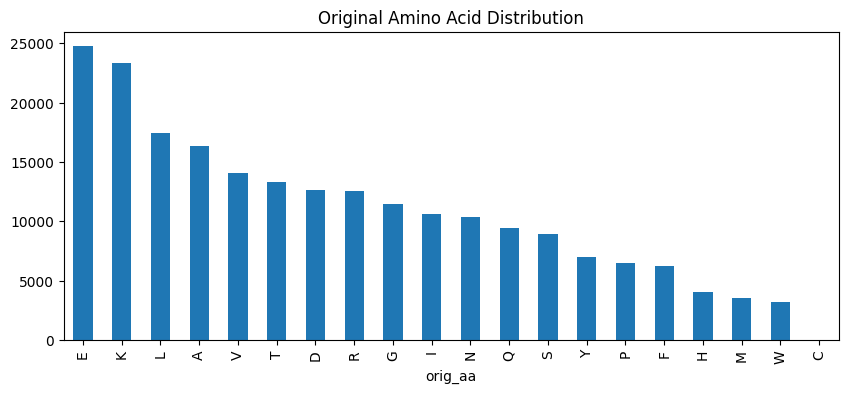

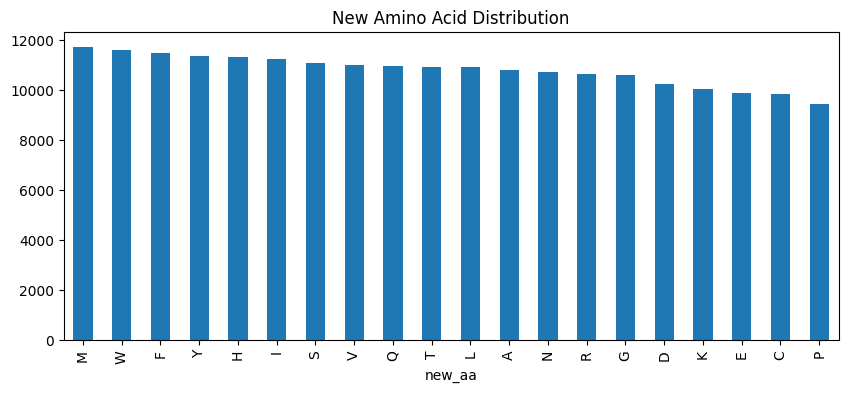


Sequence Length Statistics:
count    215731.000000
mean         52.754092
std          10.251942
min          35.000000
25%          43.000000
50%          53.000000
75%          62.000000
max          72.000000
Name: seq_len, dtype: float64


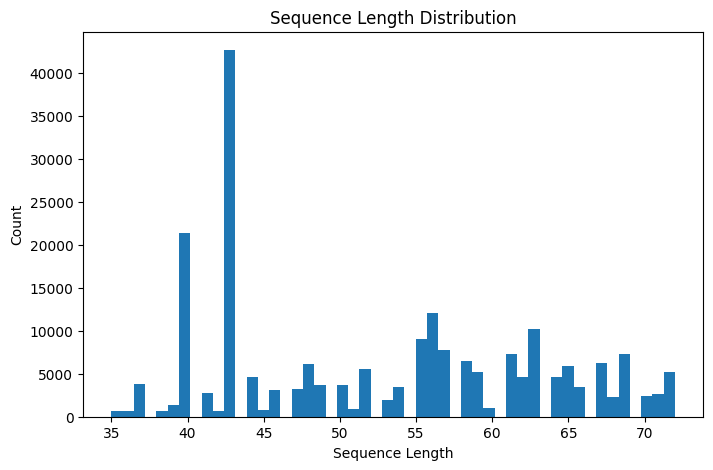


Mutations per Protein:
count     239.000000
mean      902.640167
std       194.897765
min       555.000000
25%       753.000000
50%       865.000000
75%      1048.500000
max      1356.000000
dtype: float64


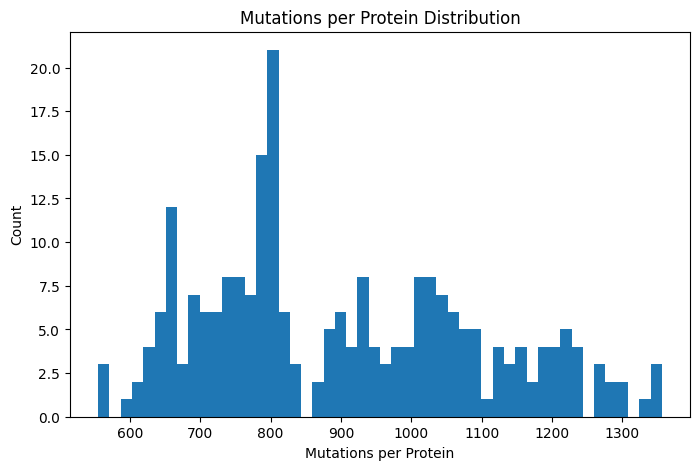

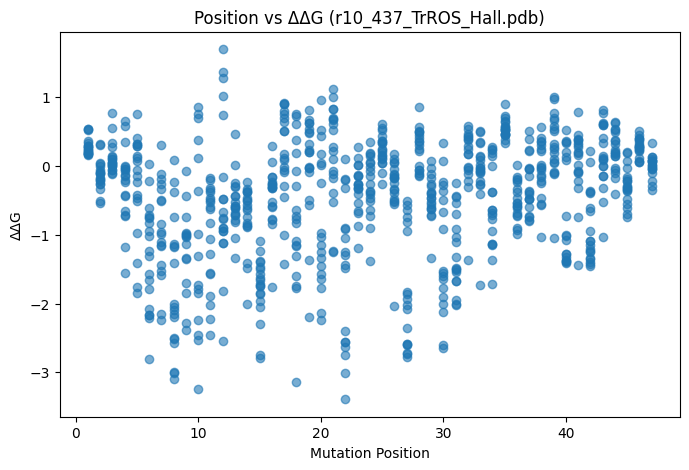

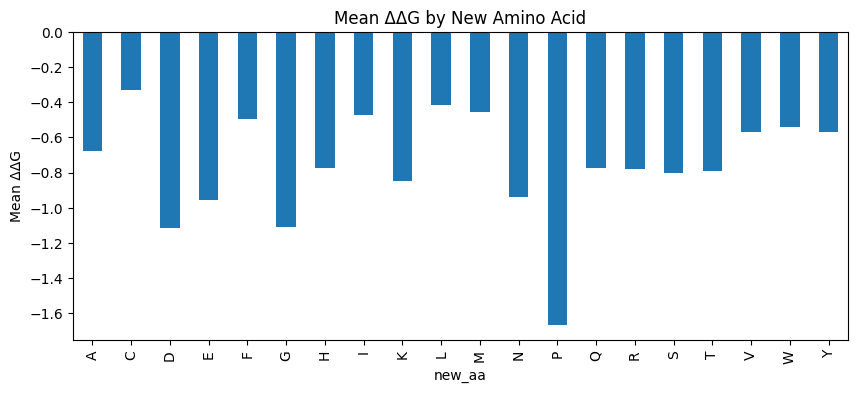

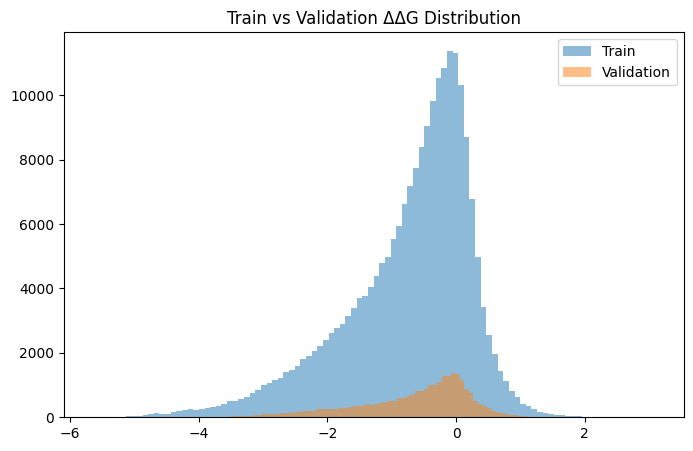


Correlation Matrix:
            ddG_ML  position   seq_len
ddG_ML    1.000000 -0.039220 -0.039508
position -0.039220  1.000000  0.313543
seq_len  -0.039508  0.313543  1.000000

Most destabilizing mutations:
        Unnamed: 0           name    ddG_ML mut_type   WT_name  \
197599      197599  2LUM.pdb_W43A -5.662802     W43A  2LUM.pdb   
197596      197596  2LUM.pdb_W43K -5.583291     W43K  2LUM.pdb   
193170      193170  1OPS.pdb_I31S -5.574280     I31S  1OPS.pdb   
190547      190547   6IWS.pdb_V9G -5.573869      V9G  6IWS.pdb   
192766      192766   1OPS.pdb_V5W -5.555543      V5W  1OPS.pdb   

                                                   aa_seq  \
197599  MQYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVATYD...   
197596  MQYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVKTYD...   
193170  SQSVVATQLIPMNTALTPAMMEGKVTNPIGSPFAEMSQLVGKQVNT...   
190547  EDYYQILGGPRNASQKEIKKAYYQLAKKYHPDTNKDDPKAKEKFSQ...   
192766  SQSVWATQLIPMNTALTPAMMEGKVTNPIGIPFAEMSQLVGKQVNT...   

                            

In [1]:
# ==============================
# PROTEIN STABILITY EDA
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. LOAD DATA
# ------------------------------

train_path = "data/mega_train.csv"   # <-- change if needed
val_path   = "data/mega_val.csv"     # <-- change if needed

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("\nColumns:\n", train_df.columns)


# ------------------------------
# 2. BASIC CLEANING
# ------------------------------

# Remove wild-type rows if present
if "mut_type" in train_df.columns:
    train_df = train_df[train_df["mut_type"] != "wt"]
    val_df   = val_df[val_df["mut_type"] != "wt"]

# Drop NaNs in target
train_df = train_df.dropna(subset=["ddG_ML"])
val_df   = val_df.dropna(subset=["ddG_ML"])

print("\nAfter cleaning:")
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)


# ------------------------------
# 3. TARGET ANALYSIS (ΔΔG)
# ------------------------------

print("\nTarget Statistics (Train):")
print(train_df["ddG_ML"].describe())
print("Skewness:", train_df["ddG_ML"].skew())
print("Kurtosis:", train_df["ddG_ML"].kurtosis())

plt.figure(figsize=(8,5))
plt.hist(train_df["ddG_ML"], bins=100)
plt.xlabel("ΔΔG")
plt.ylabel("Count")
plt.title("Distribution of ΔΔG (Train)")
plt.show()

plt.figure(figsize=(8,3))
plt.boxplot(train_df["ddG_ML"], vert=False)
plt.title("Boxplot of ΔΔG (Train)")
plt.show()


# ------------------------------
# 4. EXTRACT MUTATION FEATURES
# ------------------------------

train_df["orig_aa"] = train_df["mut_type"].str[0]
train_df["position"] = train_df["mut_type"].str[1:-1].astype(int)
train_df["new_aa"] = train_df["mut_type"].str[-1]

val_df["orig_aa"] = val_df["mut_type"].str[0]
val_df["position"] = val_df["mut_type"].str[1:-1].astype(int)
val_df["new_aa"] = val_df["mut_type"].str[-1]


# ------------------------------
# 5. AMINO ACID DISTRIBUTIONS
# ------------------------------

plt.figure(figsize=(10,4))
train_df["orig_aa"].value_counts().plot(kind="bar")
plt.title("Original Amino Acid Distribution")
plt.show()

plt.figure(figsize=(10,4))
train_df["new_aa"].value_counts().plot(kind="bar")
plt.title("New Amino Acid Distribution")
plt.show()


# ------------------------------
# 6. SEQUENCE LENGTH ANALYSIS
# ------------------------------

train_df["seq_len"] = train_df["wt_seq"].apply(len)

print("\nSequence Length Statistics:")
print(train_df["seq_len"].describe())

plt.figure(figsize=(8,5))
plt.hist(train_df["seq_len"], bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Sequence Length Distribution")
plt.show()


# ------------------------------
# 7. MUTATIONS PER PROTEIN
# ------------------------------

mutations_per_protein = train_df.groupby("WT_name").size()

print("\nMutations per Protein:")
print(mutations_per_protein.describe())

plt.figure(figsize=(8,5))
plt.hist(mutations_per_protein, bins=50)
plt.xlabel("Mutations per Protein")
plt.ylabel("Count")
plt.title("Mutations per Protein Distribution")
plt.show()


# ------------------------------
# 8. POSITION VS ΔΔG (EXAMPLE PROTEIN)
# ------------------------------

example_protein = train_df["WT_name"].iloc[0]
subset = train_df[train_df["WT_name"] == example_protein]

plt.figure(figsize=(8,5))
plt.scatter(subset["position"], subset["ddG_ML"], alpha=0.6)
plt.xlabel("Mutation Position")
plt.ylabel("ΔΔG")
plt.title(f"Position vs ΔΔG ({example_protein})")
plt.show()


# ------------------------------
# 9. MEAN ΔΔG PER AMINO ACID
# ------------------------------

mean_ddg_by_new = train_df.groupby("new_aa")["ddG_ML"].mean()

plt.figure(figsize=(10,4))
mean_ddg_by_new.plot(kind="bar")
plt.title("Mean ΔΔG by New Amino Acid")
plt.ylabel("Mean ΔΔG")
plt.show()


# ------------------------------
# 10. TRAIN VS VALIDATION COMPARISON
# ------------------------------

plt.figure(figsize=(8,5))
plt.hist(train_df["ddG_ML"], bins=100, alpha=0.5, label="Train")
plt.hist(val_df["ddG_ML"], bins=100, alpha=0.5, label="Validation")
plt.legend()
plt.title("Train vs Validation ΔΔG Distribution")
plt.show()


# ------------------------------
# 11. CORRELATION CHECK
# ------------------------------

print("\nCorrelation Matrix:")
print(train_df[["ddG_ML", "position", "seq_len"]].corr())


# ------------------------------
# 12. EXTREME OUTLIERS
# ------------------------------

print("\nMost destabilizing mutations:")
print(train_df.sort_values("ddG_ML").head())

print("\nMost stabilizing mutations:")
print(train_df.sort_values("ddG_ML").tail())

print("\nEDA COMPLETE.")